In [1]:
%matplotlib inline
import os, sys
#import modules
from utils import *
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras import backend as K

import os, json

from keras.layers import Input
from keras.optimizers import SGD, RMSprop, Adam
from enum import Enum
from keras.layers.core import Dense
from utils import save_array, load_array


DATA_HOME_DIR = '/srv/'
# DATA_HOME_DIR = '/home/ubuntu/blocks_classifier/data/dogscats' # on ec2

reload(K)
K.image_dim_ordering()

Using TensorFlow backend.
Using TensorFlow backend.


'tf'

In [2]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR  #'/sample/'

/srv


In [9]:
def get_batches(path, shuffle=True, batch_size=8, class_mode='categorical',target_size=(224,224), data_augmentation=False):
        if data_augmentation:
            gen=image.ImageDataGenerator(rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, shear_range=0.0, zoom_range=0.1, channel_shift_range=0., horizontal_flip=True, vertical_flip=True, dim_ordering='tf')
        else:
            gen=image.ImageDataGenerator(dim_ordering='tf')


        return gen.flow_from_directory(path, target_size=target_size,
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [10]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_array(fpath, filenames, titles=None):
    plots([image.load_img(fpath+f) for f in filenames], titles=titles)
    

    
#Number of images to view for each visualization task
n_view = 4

## Training and validation sets

In [11]:
im_size = (480, 640)
imgen_mult_factor = 1 # how many repetitions generated from the original dataset


In [36]:
def get_data(path, target_size=(224,224), sample=False, data_augmentation=False):
    b = get_batches(path, batch_size = 1, target_size=target_size, class_mode=None, shuffle=False, data_augmentation=data_augmentation)
    nb_items_to_return = 3 if sample is True else b.nb_sample
    print "Getting",nb_items_to_return, "images."
    return np.concatenate([b.next() for i in range(nb_items_to_return)])

val_data = np.array([], dtype=np.float32).reshape(0, 480, 640, 3)
trn_data = np.array([], dtype=np.float32).reshape(0, 480, 640, 3)




for i in range(imgen_mult_factor):
    print "augmenting data loop", i+1

    vd = get_data(path+'valid', target_size=im_size, sample=False, data_augmentation=True)
    td = get_data(path+'training', target_size=im_size, sample=False, data_augmentation=True)
    val_data = np.concatenate((val_data, vd))
    trn_data = np.concatenate((trn_data, td))


# val_data = get_data(path+'valid', target_size=im_size, sample=False, data_augmentation=True)
# trn_data = get_data(path+'training', target_size=im_size, sample=False, data_augmentation=True)
# vd = get_data(path+'valid', target_size=im_size, sample=False, data_augmentation=True)
# td = get_data(path+'training', target_size=im_size, sample=False, data_augmentation=True)
# val_data = np.concatenate((val_data, vd))
# trn_data = np.concatenate((trn_data, td))
# trn_data.shape

augmenting data loop 1
Found 88 images belonging to 2 classes.
Getting 88 images.
Found 633 images belonging to 2 classes.
Getting 633 images.


In [37]:

val_batches =  get_batches(path+'valid', batch_size = 1, shuffle=False)
trn_batches =  get_batches(path+'training', batch_size = 1, shuffle=False);

val_labels = onehot(val_batches.classes);
trn_labels = onehot(trn_batches.classes);
for i in range(imgen_mult_factor-1):
    val_labels =  np.concatenate((val_labels, onehot(val_batches.classes)))
    trn_labels =  np.concatenate((trn_labels, onehot(trn_batches.classes)))
save_array(path+'precalc/trn_labels.dat', trn_labels);
save_array(path+'precalc/val_labels.dat', val_labels);
save_array(path+'precalc/val_data.dat', val_data);
save_array(path+'precalc/trn_data.dat', trn_data);


Found 88 images belonging to 2 classes.
Found 633 images belonging to 2 classes.


#### Saves augmented dataset

In [14]:
# save_array(path+'precalc/val_data.dat', val_data)
# save_array(path+'precalc/trn_data.dat', trn_data)

#### Loads augmented dataset

In [39]:
val_data = load_array(path+'precalc/val_data.dat');
trn_data = load_array(path+'precalc/trn_data.dat');

44.3% class "one" and 55.7% class "ten"


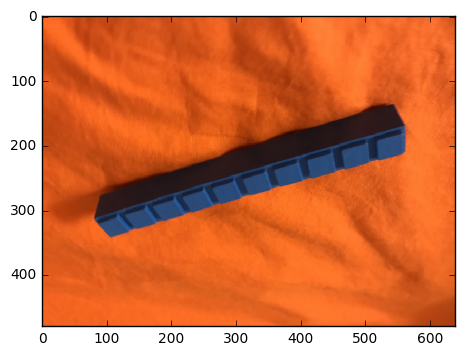

In [117]:
plot(val_data[41])
nbclasses = 100 * val_labels.sum(axis=0) / len(val_labels)
print '%.1f%% class "one" and %.1f%% class "ten"' % (nbclasses[0], nbclasses[1])

In [8]:
#### Getting the size of the original
# sizes = []
# for f in batches.filenames:
#     sizes.append(PIL.Image.open(path+'training/'+f).size)
# sizes = [PIL.Image.open(path+'training/'+f).size for f in batches.filenames] # list comprehension
# id2size = list(set(sizes)) # (640, 480)
# im_size = (640, 480)

## Fully convolutional neural net

In [41]:
class BaseModels(Enum):
    inception = "InceptionV3"
    vgg = "VGG16"
output_classes = ["one", "ten"]

In [42]:
base_model = VGG16(include_top=True, weights='imagenet') ## functional API

In [43]:
in_shape = im_size+(3,)

#### New VGG model with variable input size

In [44]:
def ConvBlock(model, num_layers, num_filters, input_size=None):
    for i in range(num_layers):
        if input_size is None:
            model.add(ZeroPadding2D((1,1)))
        else:
            model.add(ZeroPadding2D((1,1), input_shape=input_size))
            print("set input size to", input_size)
            input_size=None
        model.add(Convolution2D(num_filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))


#### large image input image

In [45]:
#base_model.summary()
large_input_model = Sequential()
ConvBlock(large_input_model, 2, 64, input_size=in_shape)
ConvBlock(large_input_model, 2, 128)
ConvBlock(large_input_model, 3, 256)
ConvBlock(large_input_model, 3, 512)
ConvBlock(large_input_model, 3, 512)

large_input_model.summary()



('set input size to', (480, 640, 3))
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_14 (ZeroPadding2D) (None, 482, 642, 3)   0           zeropadding2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 480, 640, 64)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 482, 642, 64)  0           convolution2d_17[0][0]           
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 480, 640, 64)  36928       zeropadding2d_15[0][0]           
______________________________________________________

#### copying weights from vgg

In [46]:
# base_weights = base_model.get_weights()
from keras.layers.convolutional import Convolution2D
def get_conv_layers_indexes(model):
    return [i for i,l in enumerate(model.layers) if type(l) is Convolution2D]

bigim_convlayers_idx = get_conv_layers_indexes(large_input_model)
base_model_layers_idx = get_conv_layers_indexes(base_model)
for i,idx in enumerate(base_model_layers_idx):
    print i,idx,bigim_convlayers_idx[i], type(large_input_model.layers[bigim_convlayers_idx[i]]), type(base_model.layers[idx])
    weights_in = base_model.layers[idx].get_weights()
    large_input_model.layers[bigim_convlayers_idx[i]].set_weights(weights_in)
    


0 1 1 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
1 2 3 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
2 4 6 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
3 5 8 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
4 7 11 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
5 8 13 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
6 9 15 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
7 11 18 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
8 12 20 <class 'keras.layers.convolutional.Convolution2D'> <class 'keras.layers.convolutional.Convolution2D'>
9 13 22 <class 'keras

### Precalculating features

In [47]:
%mkdir -p 'precalc'

conv_val_features = large_input_model.predict(val_data, batch_size=4, verbose=True)
save_array(path+'precalc/conv_val_feat.dat', conv_val_features)

88/88 [==============================] - 360s      8/88 [=>............................] - ETA: 418s

In [48]:
conv_trn_features = large_input_model.predict(trn_data, batch_size=1, verbose=True)
save_array(path+'precalc/conv_trn_feat.dat', conv_trn_features)

633/633 [==============================] - 2247s       2/633 [..............................] - ETA: 2318s

##### Load precalculated features

In [49]:
conv_val_features = load_array(path+'precalc/conv_val_feat.dat');
conv_trn_features = load_array(path+'precalc/conv_trn_feat.dat');
trn_labels = load_array(path+'precalc/trn_labels.dat');
val_labels = load_array(path+'precalc/val_labels.dat');
trn_data = load_array(path+'precalc/trn_data.dat');
val_data = load_array(path+'precalc/val_data.dat');
conv_trn_features.shape

(633, 15, 20, 512)

In [50]:
val_labels[0]

array([ 1.,  0.])

### Add 3 layer FC net

In [51]:
mp12 = MaxPooling2D((1,2))
mp12.get_config()

{'border_mode': 'valid',
 'dim_ordering': 'tf',
 'name': 'maxpooling2d_14',
 'pool_size': (1, 2),
 'strides': (1, 2),
 'trainable': True}

In [52]:
nf=128
p = 0.7
fc_tail_layers = [
        BatchNormalization(axis=1, input_shape=large_input_model.layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p),
        Convolution2D(2,3,3, border_mode='same', name='last_conv'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
]

In [53]:
fc_tail_model = Sequential(fc_tail_layers)

In [54]:
fc_tail_model.compile(Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
# fc_tail_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_5 (BatchNorma (None, 15, 20, 512)   60          batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_30 (Convolution2D) (None, 15, 20, 128)   589952      batchnormalization_5[0][0]       
____________________________________________________________________________________________________
batchnormalization_6 (BatchNorma (None, 15, 20, 128)   60          convolution2d_30[0][0]           
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 15, 20, 128)   0           batchnormalization_6[0][0]       
___________________________________________________________________________________________

In [55]:
l = fc_tail_model.get_layer('last_conv')

## Fit

In [56]:
batch_size = 128
trn_data.shape

(633, 480, 640, 3)

In [57]:
fc_tail_model.fit(conv_trn_features,trn_labels, batch_size=batch_size, nb_epoch = 14, validation_data=(conv_val_features, val_labels))

Train on 633 samples, validate on 88 samples
Epoch 1/14
633/633 [==============================] - 36s - loss: 0.8334 - acc: 0.5987 - val_loss: 0.5933 - val_acc: 0.6818
Epoch 2/14
633/633 [==============================] - 34s - loss: 0.4847 - acc: 0.7725 - val_loss: 0.5883 - val_acc: 0.7727
Epoch 3/14
633/633 [==============================] - 33s - loss: 0.2134 - acc: 0.9321 - val_loss: 0.7088 - val_acc: 0.8295

In [58]:
fc_tail_model.save_weights(path+'precalc/fc_weights_cubes_dp06.h5');

In [59]:
fc_tail_model.load_weights(path+'precalc/fc_weights_cubes_dp06.h5');

#### Getting the output of an intermediate layer

In [60]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
heatmap_model = Model(fc_tail_model.input, fc_tail_model.get_layer('last_conv').output)

In [130]:
trn_labels[0][0] == 1

True

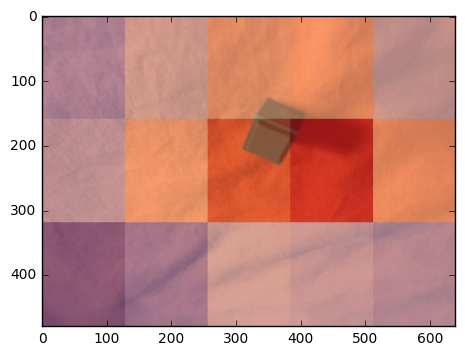

In [133]:
input_num = 25


def get_heatmap(inp, im_size=(480, 640)):
    hm_val = heatmap_model.predict(inp)
    hm_one = scipy.misc.imresize(hm_val[0,:,:,0], im_size, interp='nearest')
    hm_ten = scipy.misc.imresize(hm_val[0,:,:,1], im_size, interp='nearest')
    return (hm_one, hm_ten)

def plot_heatmap(type="trn", idx = 0):
    if type is "trn":
        input_with_batch_num = np.expand_dims(conv_trn_features[idx],axis=0)
        background_image = trn_data[idx]
        is_one = trn_labels[idx][0] == 1
    else:
        input_with_batch_num = np.expand_dims(conv_val_features[idx],axis=0) # adds another bracket...
        background_image = val_data[idx]
        is_one = val_labels[idx][0] == 1
    (hm_one, hm_ten) = get_heatmap(input_with_batch_num, im_size=(480, 640))
   
    plot(background_image)
    if is_one:
        plt.imshow(hm_one, cmap='coolwarm', alpha=0.5)
    else:
        plt.imshow(hm_ten, cmap='coolwarm', alpha=0.5)


    
plot_heatmap("val", 0)



# Check the results

In [42]:
coreml_model.short_description = 'Categorize within 1 or 10 math-u-see blocks - Adam + image augmentation'

In [43]:
coreml_model.save(path+"vgg_image_adam_image_aug.mlmodel")